* python 실행 경로 확인 
    - python 가상 환경을 사용 중이라면 가상 환경의 path 가 맞는지 확인한다. 


In [1]:
%gui qt5
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

import sys
print(sys.executable)

d:\1git\kw_condition\.venv\Scripts\python.exe


### 1. 객체 생성

In [2]:
from kw_condition import KiwoomOpenApiPlus
from kw_condition.utils import common_util

from PySide2.QtWidgets import QApplication

myApp = None
if isinstance(QApplication.instance(), type(None)):
    print('make instance')
    myApp = QApplication([])
else:
    print("use already")
    myApp = QApplication.instance()

kw_obj = KiwoomOpenApiPlus()

make instance


### 2. 서버접속
* 자동로그인이 설정되어 있는 경우 로그인이 자동으로 처리 되며, 그렇지 않은 경우 팝업 창에서 수동으로 아이디, 비밀번호 정보를 입력해야함 
- TODO
    * 자동 로그인 설정되지 않은 상태서 로그인 정보를 외부에서 입력한 경우 매크로로 자동처리 할수 있도록 해야함 pywinauto

In [4]:
kw_obj.tryConnect()
common_util.process_qt_events(kw_obj.isConnected, 60)

* 15:04:02.233931 tryConnect 


### 3. 서버 접속 상태 확인 

In [5]:
kw_obj.isConnected()

True

### 4. TR (주식기본정보요청) - Single Data

아래 처럼 직접 TR 요청에 필요한 입력값을 설정해 요청하고, 이후 들어오는 이벤트 또한 직접 처리해주는 방식으로 사용할 수 있다.

In [13]:
rqname = '주식기본정보요청'
trcode = 'opt10001'
screen_no = '0001'  # 화면번호, 0000 을 제외한 4자리 숫자 임의로 지정, None 의 경우 내부적으로 화면번호 자동할당

inputs = {'종목코드': '005930'}

kw_obj.add_transaction(rqname, trcode, inputs, screen_no)

common_util.process_qt_events(kw_obj.is_transaction_result_avaliable(rqname), 5)

print( kw_obj.get_transaction_result(rqname) )


* 15:05:51.689748 request_transaction  {'rqname': '주식기본정보요청', 'trcode': 'opt10001', 'screen_no': '0001', 'inputs': {'종목코드': '005930'}}
* 15:05:51.810538 _OnReceiveTrData  sScrNo: 0001, rQName: 주식기본정보요청, trCode: opt10001, recordName: , prevNext 0
['005930', '+78500', '-42300', '60400']


### 4. TR(주식일봉차트조회요청) - Multi Data  

In [8]:
import datetime

rqname = '주식일봉차트조회요청'
trcode = 'opt10081'
screen_no = '0002'  # 화면번호, 0000 을 제외한 4자리 숫자 임의로 지정, None 의 경우 내부적으로 화면번호 자동할당

current_time_str = datetime.datetime.now().strftime('%Y%m%d')

inputs = {'종목코드': '005930', '기준일자' : current_time_str, "수정주가구분": '1'}

kw_obj.add_transaction(rqname, trcode, inputs, screen_no)

common_util.process_qt_events(kw_obj.is_transaction_result_avaliable(rqname), 5)

daily_dict = kw_obj.get_transaction_result(rqname)
#print(daily_dict)





* 15:05:06.155096 request_transaction  {'rqname': '주식일봉차트조회요청', 'trcode': 'opt10081', 'screen_no': '0002', 'inputs': {'종목코드': '005930', '기준일자': '20220818', '수정주가구분': '1'}}
* 15:05:07.266811 _OnReceiveTrData  sScrNo: 0002, rQName: 주식일봉차트조회요청, trCode: opt10081, recordName: , prevNext 2


### 4. TR(주식일봉차트조회요청) - Multi Data - 차트 출력  

             Open   High    Low  Close    Volume
Date                                            
2020-03-17  46900  49650  46700  47300  51218151
2020-03-18  47750  48350  45600  45600  40152623
2020-03-19  46400  46650  42300  42950  56925513
2020-03-20  44150  45500  43550  45400  49730008
2020-03-23  42600  43550  42400  42500  41701626


d:\1git\kw_condition\.venv\lib\site-packages\mplfinance\_arg_validators.py:36: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


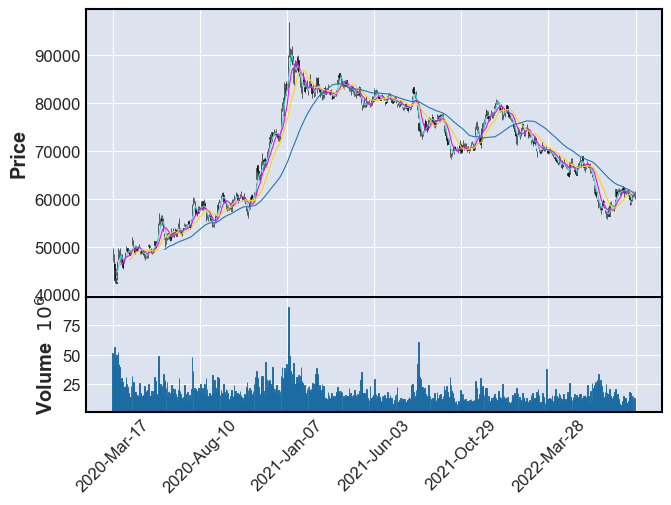

In [9]:
import mplfinance as mpf

daily_df = pd.DataFrame.from_dict( daily_dict, orient='index', columns=["StockCode", "Date", "Open", "High", "Low", "Close", "Volume"])

# 일봉 조회의 경우 종목 코드가 2번째 row 부터 공백이므로 삭제 
daily_df.drop(columns='StockCode', axis =1, inplace = True)

# string date -> datetime 
daily_df['Date'] = pd.to_datetime( daily_df['Date'], format = '%Y%m%d') 

# str to int
selected_cols = ["Open", "High", "Low", "Close", "Volume"]
daily_df[ selected_cols ] = daily_df[selected_cols].astype('int')

daily_df = daily_df.set_index('Date')

daily_df = daily_df.sort_values(by= 'Date')

print(daily_df.head(5))

# 5, 10 , 20 , 60 일 평균 선 추가 
mpf.plot(daily_df, type='candle', mav=(5, 10, 20, 60), volume= True)



### 4. TR(주식일봉차트조회요청) - Multi Data - 연속 조회 

### 5. 조건 검색 
이후 예시의 정상동작을 위해서는 아래에서 사용되는 조건들과 같은 이름을 가지는 조건들이 미리 저장되어 있어야 한다.

참고로 조건들을 편집하고 저장하는건 영웅문 HTS 내부에서만 가능하기 때문에 따로 HTS 를 열어 편집해주어야 한다.

### 6. 실시간 조건 검색 

### 7. 주문 처리